In [1]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset

In [2]:
from resnet_model import *

In [3]:
batch_size = 64

data_train = dset.MNIST('./', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                 transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(dset.MNIST('./', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((224,224)),
                               transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

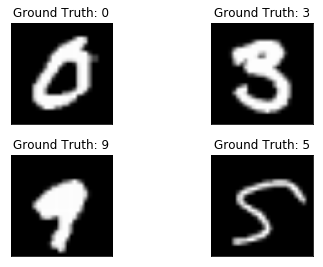

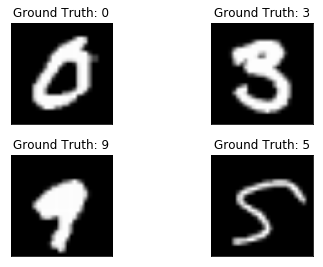

In [4]:
examples = enumerate(train_loader)
batch_idx, (xs, ys) = next(examples)
fig = plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.imshow(xs[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(ys[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
import tqdm
from tqdm import tqdm

def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        with tqdm(total=len(train_loader)) as progress_bar:
            for i_step, (x, y) in enumerate(train_loader):
                prediction = model(x)   
                loss_value = loss(prediction, y)
                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()
            
                _, indices = torch.max(prediction, 1)
                correct_samples_batch = torch.sum(indices == y)
                correct_samples += torch.sum(indices == y)
                total_samples_batch = y.shape[0]
                total_samples += y.shape[0]
            
                loss_accum += loss_value
                
                progress_bar.update()
                progress_bar.set_description(f'Train Loss at Batch {i_step}: {loss_value} , \
                                             Accuracy is {float(correct_samples_batch)/total_samples_batch}')

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        scheduler.step()
        
    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    val_accuracy = 0
    correct = 0
    total = 0
    for i_step, (x, y) in enumerate(loader):
        pred = model(x)
        
        _, indices = torch.max(pred, 1)
        correct += torch.sum(indices == y)
        total += y.shape[0]
        
        val_accuracy = float(correct)/total
        
    return val_accuracy

In [ ]:
resnet18 = ResNet([2,2,2,2], 3, 10, False)

resnet18.type(torch.FloatTensor)


parameters = resnet18.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 2)
loss_history, train_history, val_history = train_model(resnet18, train_loader, val_loader, loss, optimizer, scheduler, 5)

Train Loss at Batch 3: 2.275979995727539 ,                                              Accuracy is 0.234375:   3%|▎         | 4/125 [00:23<11:34,  5.74s/it] 

In [9]:
resnet50 = ResNet([3, 4, 6, 3], 3, 10, True)
print(list(resnet50.modules()))

[ResNet(
  (_conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_relu): ReLU(inplace)
  (_maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_block1): Sequential(
    (Bottleneck_block_64x64_0): BottleneckBlock(
      (conv_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (projection_shortcut): Sequential(
        (0): Conv2d(64, 256, ker